In [25]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 3種類のマッチング結果の比較

In [26]:
# 他の結果を読み込み
df_career = pd.read_csv("../outputs/matching_results_project_true.csv")
df_skill = pd.read_csv("../outputs/matching_results_skill.csv")
df_both = pd.read_csv("../outputs/matching_results_both.csv")

print(f"Career results: {len(df_career)}")
print(f"Skill results: {len(df_skill)}")
print(f"Both results: {len(df_both)}")

Career results: 10000
Skill results: 10000
Both results: 10000


## CSVの比較

In [27]:
# カラム名を変更して結合の準備
df_career_renamed = df_career.rename(columns={
    "user_id": "career_user_id",
    "similarity_score": "career_score"
})[['project_id', 'project_name', 'rank', 'career_user_id', 'career_score']]

df_skill_renamed = df_skill.rename(columns={
    "user_id": "skill_user_id",
    "similarity_score": "skill_score"
})[['project_id', 'rank', 'skill_user_id', 'skill_score']]

df_both_renamed = df_both.rename(columns={
    "user_id": "both_user_id",
    "similarity_score": "both_score"
})[['project_id', 'rank', 'both_user_id', 'both_score']]

# 結合
df_merged = pd.merge(df_career_renamed, df_skill_renamed, on=['project_id', 'rank'], how='outer')
df_merged = pd.merge(df_merged, df_both_renamed, on=['project_id', 'rank'], how='outer')

# 結果の表示
print("Merged DataFrame shape:", df_merged.shape)
display(df_merged.head())

# CSV保存
df_merged.to_csv("../outputs/matching_comparison.csv", index=False)
print("比較用CSVを保存しました: ../outputs/matching_comparison.csv")

Merged DataFrame shape: (10000, 9)


,project_id,project_name,rank,career_user_id,career_score,skill_user_id,skill_score,both_user_id,both_score
0,1,旅行予約システム設計,1,204,0.734799,288,0.167680,204,0.734799
1,1,旅行予約システム設計,2,37,0.719627,210,0.164912,37,0.719627
2,1,旅行予約システム設計,3,130,0.717594,89,0.164912,275,0.692790
3,1,旅行予約システム設計,4,40,0.700897,31,0.164912,40,0.691461
4,1,旅行予約システム設計,5,275,0.692790,219,0.162780,70,0.688740


比較用CSVを保存しました: ../outputs/matching_comparison.csv


## Jaccard係数を使って比較

In [28]:
def calculate_jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

project_ids = df_career["project_id"].unique()
similarities = []

for pid in tqdm(project_ids, desc="比較中"):
    users_career = df_career[df_career["project_id"] == pid]["user_id"].head(10).tolist()
    users_skill = df_skill[df_skill["project_id"] == pid]["user_id"].head(10).tolist()
    users_both = df_both[df_both["project_id"] == pid]["user_id"].head(10).tolist()
    
    sim_c_s = calculate_jaccard_similarity(users_career, users_skill)
    sim_c_b = calculate_jaccard_similarity(users_career, users_both)
    sim_s_b = calculate_jaccard_similarity(users_skill, users_both)
    
    similarities.append({
        "project_id": pid,
        "career_vs_skill": sim_c_s,
        "career_vs_both": sim_c_b,
        "skill_vs_both": sim_s_b
    })

df_sim = pd.DataFrame(similarities)
print("\n【トップ10候補者のJaccard係数平均】")
print(df_sim.mean(numeric_only=True))

比較中: 100%|██████████| 1000/1000 [00:00<00:00, 6069.54it/s]


【トップ10候補者のJaccard係数平均】
project_id         500.500000
career_vs_skill      0.010194
career_vs_both       0.771357
skill_vs_both        0.005924
dtype: float64


## 箱ひげ図

箱ひげ図を保存しました: ../outputs/matching_comparison_boxplot.png


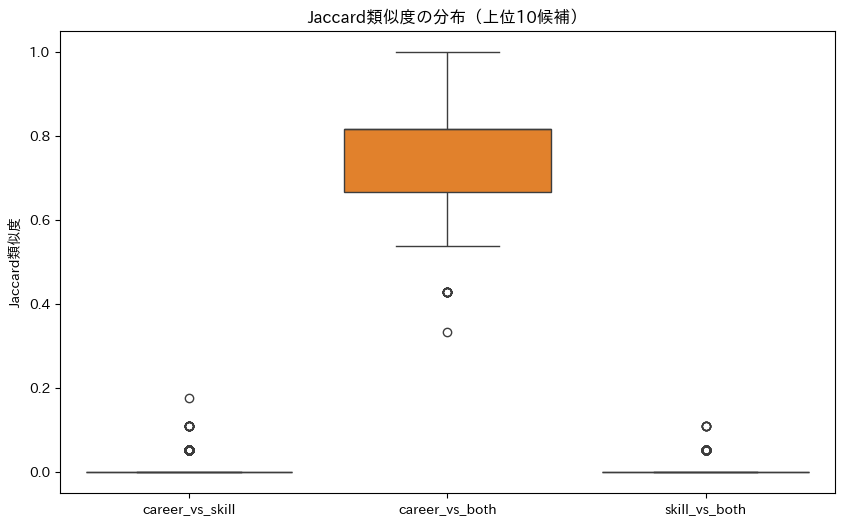

In [29]:
plt.rcParams['font.family'] = 'IPAexGothic'

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_sim[['career_vs_skill', 'career_vs_both', 'skill_vs_both']])
plt.title('Jaccard類似度の分布（上位10候補）')
plt.ylabel('Jaccard類似度')
plt.savefig('../outputs/matching_comparison_boxplot.png')
print("箱ひげ図を保存しました: ../outputs/matching_comparison_boxplot.png")

# 定性分析：マッチング理由の解明

なぜその人材がマッチしたのか、共通するキーワード（名詞）を抽出して分析します。

In [30]:
from sudachipy import dictionary, tokenizer

# 定性分析用の生データを読み込み
project_df = pd.read_csv("../data/raw/project-true.csv")
user_df = pd.read_csv("../data/raw/user_work_histories.csv")
print(f"Project data loaded: {len(project_df)} records")
print(f"User history data loaded: {len(user_df)} records")

Project data loaded: 1000 records
User history data loaded: 911 records


In [31]:
def extract_nouns(text: str) -> list[str]:
    """
    テキストから名詞を抽出する関数
    """
    if pd.isna(text):
        return []

    tokenizer_obj = dictionary.Dictionary(dict="full").create()
    mode = tokenizer.Tokenizer.SplitMode.C
    morphemes = tokenizer_obj.tokenize(str(text), mode)

    nouns = []
    for m in morphemes:
        pos = m.part_of_speech()[0]
        if pos == "名詞":
            nouns.append(m.surface())
    return nouns

In [32]:
def get_project_text(project_id: int, project_df: pd.DataFrame) -> str:
    """プロジェクトのテキストを取得"""
    project = project_df[project_df['id'] == project_id].iloc[0]
    return f"{project['name']} {project['description']}"

def get_user_text(user_id: int, user_df: pd.DataFrame, method: str) -> str:
    """
    手法に応じてユーザーのテキストを取得
    method: 'career', 'skill', 'both'
    """
    user_data = user_df[user_df['user_id'] == user_id]
    
    # スキルカラムの定義（簡易版）
    skill_columns = [
        'HTML', 'CSS', 'JavaScript', 'TypeScript', 'Python', 'Ruby', 'PHP', 'Java', 
        'C#', 'C++', 'Go', 'Rust', 'Swift', 'Kotlin', 'React', 'Vue', 'Angular', 
        'Node.js', 'Express', 'Django', 'Flask', 'Rails', 'Laravel', 'Spring', '.NET', 
        'AWS', 'Azure', 'GCP', 'Docker', 'Kubernetes', 'MySQL', 'PostgreSQL', 'MongoDB', 
        'Git', 'Linux', 'Agile', 'Scrum'
    ]
    available_skill_columns = [col for col in skill_columns if col in user_df.columns]

    text_parts = []
    
    if method in ['career', 'both']:
        # 職歴テキスト
        for _, row in user_data.iterrows():
            text_parts.append(f"{row['project_name']} {row['description']} {row['role']}")
            
    if method in ['skill', 'both']:
        # スキルテキスト
        user_skills = set()
        for _, row in user_data.iterrows():
            for col in available_skill_columns:
                if row[col] == 1:
                    user_skills.add(col)
        text_parts.append(" ".join(user_skills))
        
    return " ".join(text_parts)

In [33]:
def analyze_match_reason(project_id: int, user_id: int, method: str):
    """
    マッチング理由の分析（共通キーワードの抽出）
    """
    print(f"--- Analysis for Project {project_id} vs User {user_id} ({method}) ---")
    
    # テキスト取得
    p_text = get_project_text(project_id, project_df)
    u_text = get_user_text(user_id, user_df, method)
    
    # 名詞抽出
    p_nouns = set(extract_nouns(p_text))
    u_nouns = set(extract_nouns(u_text))
    
    # 共通キーワード
    common_keywords = p_nouns.intersection(u_nouns)
    
    print(f"Project Keywords (Top 5): {list(p_nouns)[:5]}...")
    print(f"User Keywords (Top 5): {list(u_nouns)[:5]}...")
    print(f"\n【共通キーワード ({len(common_keywords)}語)】")
    print(", ".join(common_keywords))
    return common_keywords

In [37]:
# プロジェクト1の上位マッチングを分析
target_project_id = 1

# 各手法の1位のユーザーを取得
top_career = df_career[df_career['project_id'] == target_project_id].iloc[0]['user_id']
top_skill = df_skill[df_skill['project_id'] == target_project_id].iloc[0]['user_id']
top_both = df_both[df_both['project_id'] == target_project_id].iloc[0]['user_id']

print(f"Project {target_project_id} Top Matches:")
print(f"Career: User {top_career}")
print(f"Skill: User {top_skill}")
print(f"Both: User {top_both}\n")

analyze_match_reason(target_project_id, top_career, 'career')
print("\n" + "="*50 + "\n")
analyze_match_reason(target_project_id, top_skill, 'skill')
print("\n" + "="*50 + "\n")
analyze_match_reason(target_project_id, top_both, 'both')

Project 1 Top Matches:
Career: User 204
Skill: User 288
Both: User 204

--- Analysis for Project 1 vs User 204 (career) ---
Project Keywords (Top 5): ['作成', 'ドキュメント', '予約', '運用', '旅行']...
User Keywords (Top 5): ['インフラエンジニア', '基本設計', '詳細', 'テスト', 'バックエンド']...

【共通キーワード (7語)】
導入, テスト, システム設計, インフラ, プロジェクト, 自動, 構築


--- Analysis for Project 1 vs User 288 (skill) ---
Project Keywords (Top 5): ['作成', 'ドキュメント', '予約', '運用', '旅行']...
User Keywords (Top 5): ['CSS', 'Java', 'Node', 'Scrum', 'Flask']...

【共通キーワード (0語)】



--- Analysis for Project 1 vs User 204 (both) ---
Project Keywords (Top 5): ['作成', 'ドキュメント', '予約', '運用', '旅行']...
User Keywords (Top 5): ['インフラエンジニア', '基本設計', '詳細', 'テスト', 'バックエンド']...

【共通キーワード (7語)】
導入, テスト, システム設計, インフラ, プロジェクト, 自動, 構築


{'インフラ', 'システム設計', 'テスト', 'プロジェクト', '導入', '構築', '自動'}